100%|██████████| 170498071/170498071 [00:03<00:00, 48421878.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training AlexNet...
Epoch [1/5], Step [100/1563], Loss: 2.2617
Epoch [1/5], Step [200/1563], Loss: 2.0315
Epoch [1/5], Step [300/1563], Loss: 1.9931
Epoch [1/5], Step [400/1563], Loss: 1.9184
Epoch [1/5], Step [500/1563], Loss: 1.8529
Epoch [1/5], Step [600/1563], Loss: 1.8679
Epoch [1/5], Step [700/1563], Loss: 1.8346
Epoch [1/5], Step [800/1563], Loss: 1.8079
Epoch [1/5], Step [900/1563], Loss: 1.7809
Epoch [1/5], Step [1000/1563], Loss: 1.7524
Epoch [1/5], Step [1100/1563], Loss: 1.7226
Epoch [1/5], Step [1200/1563], Loss: 1.6829
Epoch [1/5], Step [1300/1563], Loss: 1.6713
Epoch [1/5], Step [1400/1563], Loss: 1.6600
Epoch [1/5], Step [1500/1563], Loss: 1.6119
Epoch [2/5], Step [100/1563], Loss: 1.6012
Epoch [2/5], Step [200/1563], Loss: 1.5437
Epoch [2/5], Step [300/1563], Loss: 1.6181
Epoch [2/5], Step [400/1563], Loss: 1.5453
Epoch [2/5], Step [500/1563], Loss: 1.5258
Epoch [2/5], Step [600/1563], Loss: 1.5716
Epoch [2/5], Step [700/1563], Loss: 1.5629
Epoch [2/5], Step [800/1563]

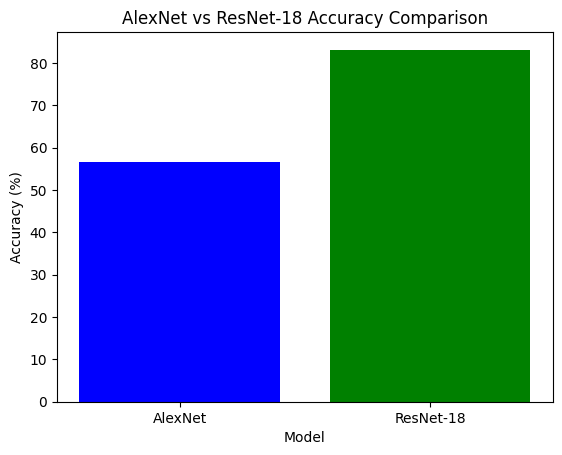

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

# Define AlexNet model
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define ResNet18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.model = torchvision.models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Prepare CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for both models
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train function
def train_model(model, criterion, optimizer, num_epochs=5):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0
    print('Training Finished')

# Test function to calculate accuracy
def test_model(model):
    model = model.to(device)
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Initialize models, loss function and optimizers
alexnet = AlexNet(num_classes=10)
resnet18 = ResNet18(num_classes=10)

criterion = nn.CrossEntropyLoss()
alexnet_optimizer = optim.Adam(alexnet.parameters(), lr=0.001)
resnet18_optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

# Train both models
print("Training AlexNet...")
train_model(alexnet, criterion, alexnet_optimizer)

print("Training ResNet-18...")
train_model(resnet18, criterion, resnet18_optimizer)

# Test both models
print("Testing AlexNet...")
alexnet_accuracy = test_model(alexnet)
print(f'AlexNet Accuracy: {alexnet_accuracy:.2f}%')

print("Testing ResNet-18...")
resnet18_accuracy = test_model(resnet18)
print(f'ResNet-18 Accuracy: {resnet18_accuracy:.2f}%')

# Plot accuracy comparison
models = ['AlexNet', 'ResNet-18']
accuracies = [alexnet_accuracy, resnet18_accuracy]

plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('AlexNet vs ResNet-18 Accuracy Comparison')
plt.show()


In [6]:
from prettytable import PrettyTable
def hook_fn(module, input, output):
    min_val = torch.min(output).item()
    max_val = torch.max(output).item()
    output_ranges.append((module, min_val, max_val))
def print_layer_info(model, model_name):
    table = PrettyTable()
    table.field_names = ["Layer", "Output Min", "Output Max", "Param #"]

    # Hook the model layers
    global output_ranges
    output_ranges = []
    hooks = []
    for layer in model.modules():
        hooks.append(layer.register_forward_hook(hook_fn))

    # Run a test image to collect output data
    test_image = torch.randn(1, 3, 224, 224).to(device)  # A dummy image
    model(test_image)  # Forward pass

    # Remove hooks after forward pass
    for hook in hooks:
        hook.remove()

    # Print layer information
    for layer, min_val, max_val in output_ranges:
        param_count = sum(p.numel() for p in layer.parameters() if p.requires_grad)
        table.add_row([str(layer), min_val, max_val, param_count])

    print(f"\n{model_name} Layer Outputs and Parameter Count:")
    print(table)
print_layer_info(alexnet, "AlexNet")
print_layer_info(resnet18, "ResNet-18")


AlexNet Layer Outputs and Parameter Count:
+--------------------------------------------------------------------------------------+---------------------+---------------------+----------+
|                                        Layer                                         |      Output Min     |      Output Max     | Param #  |
+--------------------------------------------------------------------------------------+---------------------+---------------------+----------+
|          Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))          |  -6.343830108642578 |  6.240312576293945  |  23296   |
|                                  ReLU(inplace=True)                                  |         0.0         |  6.240312576293945  |    0     |
|      MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)      |         0.0         |  6.240312576293945  |    0     |
|          Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))          |  -9